# Analysis of Model

Here, we load the weights of a fully trained model of the Gaussian beam propagation in order to do graphics and other stuff.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from time import time

In [2]:
folder = '/home/jakob/Documents/BachelorThesis/ThesisTeX/graphics/chapter4_periodic'

In [3]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

In [4]:
tf.random.set_seed(42) # always the same seed - reproducibility

In [5]:
pi = tf.constant(np.pi, dtype=DTYPE) # everybody needs some pi in their life

2022-06-03 07:17:56.440824: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-03 07:17:56.441525: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 07:17:56.442996: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
plt.style.use('./../rc.mplstyle')      # if in docker comment out,
                                        # if not, matplotlibrc is there

In [7]:
plt.rcParams['axes.grid'] = False   # otherwise he dislikes colorplots

### parameters

In [8]:
A_0 = 0.5
k = 2.
z_0 = 0.5

x_lb = -5.
x_ub = 5.

y_lb = -5.
y_ub = 5.

z_lb = 0.
z_ub = 1.

In [9]:
Nc = 50000  # collocation points
N_test = 101 # test points (will be done in a grid, so cubic)
N0 = 2000 # initial conditions points
Nb = 2000 # boundary points

mid = 50 ## midpoint of arrays so we get x[mid] = 0

In [37]:
# x and z collocation points for PDE residual

x = tf.random.uniform((Nc, 1), x_lb, x_ub, dtype=DTYPE)
y = tf.random.uniform((Nc, 1), y_lb, y_ub, dtype=DTYPE)
z = tf.random.uniform((Nc, 1), z_lb, z_ub, dtype=DTYPE)
XYZ = tf.concat([x, y, z], axis=1)

xtest = np.linspace(x_lb, x_ub, N_test)
#print(xtest)
ytest = np.linspace(y_lb, y_ub, N_test)
ztest = np.linspace(z_lb, z_ub, N_test)
xtestm_plot, ztestm_plot = np.meshgrid(xtest, ztest)
xtestm, ytestm, ztestm = np.meshgrid(xtest, ytest, ztest)
xtestm_resh = xtestm.flatten().reshape(N_test**3, 1)
ytestm_resh = ytestm.flatten().reshape(N_test**3, 1)
ztestm_resh = ztestm.flatten().reshape(N_test**3, 1)

xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
ytestm_resh_tf = tf.convert_to_tensor(ytestm_resh, dtype=DTYPE)
ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)
XYZtest = tf.concat([xtestm_resh_tf, ytestm_resh_tf, ztestm_resh_tf], axis=1)

# x and z for z boundary condition
    # note that z = 1 in our case is like an initial condition
    # and is thus treated as such

z0 = tf.zeros((N0, 1), dtype=DTYPE)
x0 = tf.random.uniform((N0, 1), x_lb, x_ub, dtype=DTYPE)
y0 = tf.random.uniform((N0, 1), y_lb, y_ub, dtype=DTYPE)
XYZ0 = tf.concat([x0, y0, z0], axis=1)

# x, y and z for x boundary conditions

xb = tf.random.uniform((Nb, 1), x_lb, x_ub, dtype=DTYPE)
yb = tf.random.uniform((Nb, 1), y_lb, y_ub, dtype=DTYPE)
zb = tf.random.uniform((Nb, 1), z_lb, z_ub, dtype=DTYPE)

xlb = tf.ones((Nb, 1), dtype=DTYPE) * x_lb
XYZ_xlb = tf.concat([xlb, yb, zb], axis=1)
xub = tf.ones((Nb, 1), dtype=DTYPE) * x_ub
XYZ_xub = tf.concat([xub, yb, zb], axis=1)

ylb = tf.ones((Nb, 1), dtype=DTYPE) * y_lb
XYZ_ylb = tf.concat([xb, ylb, zb], axis=1)
yub = tf.ones((Nb, 1), dtype=DTYPE) * y_ub
XYZ_yub = tf.concat([xb, yub, zb], axis=1)


# FOR PLOTS

x_np = np.linspace(x_lb, x_ub, num=101)
y_np = np.linspace(y_lb, y_ub, num=101)
z_np = np.linspace(z_lb, z_ub, num=101)

x_npmesh2, y_npmesh2, z_npmesh2 = np.meshgrid(x_np, y_np, z_np)
x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)

In [11]:
print(xtest[50])

0.0


### functions

In [12]:
def u_exact_np(x, y, z): # \frac{A_0}{b} \exp[-R_0] \left(z \cos R - z_0 \sin R\right)
    b = z_0**2 + z**2
    R_0 = k*z_0*(x**2 + y**2) / (2*b)
    R = k*z*(x**2 + y**2) / (2*b)
    return (A_0 / b) * np.exp(-R_0) * (z*np.cos(R) - z_0*np.sin(R))

def v_exact_np(x, y, z): # -\frac{A_0}{b} \exp[-R_0] \left(z \sin R + z_0 \cos R\right)
    b = z_0**2 + z**2
    R_0 = k*z_0*(x**2 + y**2) / (2*b)
    R = k*z*(x**2 + y**2) / (2*b)
    return (A_0 / b) * np.exp(-R_0) * (z*np.sin(R) + z_0*np.cos(R))

def v_init(x0,y0):
    return (A_0 / z_0) * np.exp(- k * (x0**2 + y0**2) / (2*z_0))

In [13]:
def init_model(L = 4, N = 32):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(3))
    for _ in range(L):
        model.add(tf.keras.layers.Dense(N,
                                       activation=tf.keras.activations.get('tanh'),
                                       kernel_initializer='glorot_normal')) # why not random?
    model.add(tf.keras.layers.Dense(2)) # 2d output (u and v)
    return model

In [14]:
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

def plot_model():
    A_plot = model(XYZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = (u_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    v_plot = (v_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3), dpi=500)
    
    fig.suptitle('model prediction')    

    line1 = ax1.pcolormesh(ztestm_plot, xtestm_plot, u_plot, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
    cbar1 = fig.colorbar(line1, ax=ax1)
    cbar1.set_label(r'$u(x,y=0,z)$')
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x$')
    
    line2 = ax2.pcolormesh(ztestm_plot, xtestm_plot, v_plot, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
    cbar2 = fig.colorbar(line2, ax=ax2)
    cbar2.set_label(r'$v(x,y=0,z)$')
    ax2.set_xlabel(r'$z$')
    
    line3 = ax3.pcolormesh(ztestm_plot, xtestm_plot, u_plot**2 + v_plot**2, cmap = cm.afmhot_r, vmin=0, vmax=1.1)
    cbar3 = fig.colorbar(line3, ax=ax3)
    cbar3.set_label(r'$|A(x,y=0,z)|^2$')
    ax3.set_xlabel(r'$z$')
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

In [15]:
def plot_model_1D():
    A_plot = model(XYZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    
    u_plot = (u_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    v_plot = (v_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    
    fig, ax = plt.subplots(1, figsize=(4,3))
    
    fig.suptitle('model prediction')    

    ax.plot(ztestm_plot[:,0], (u_plot**2 + v_plot**2)[:, mid])
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$|A(x=0,y=0,z)|^2$')
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

In [16]:
def plot_reference():
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3), dpi=500)

    fig.suptitle('exact')
    
    
    u_reference = (u_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    v_reference = (v_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    
    line1 = ax1.pcolormesh(z_npmesh2.T[:,:,0], x_npmesh2[:,:,0], u_reference , vmin=-1.5, vmax=1.1, cmap = cm.afmhot_r)
    ax1.set_xlabel('$z$')
    ax1.set_ylabel('$x$')
    cmap1 = fig.colorbar(line1, ax=ax1)
    cmap1.set_label('$u(x,y=0,z)$')

    line2 = ax2.pcolormesh(z_npmesh2.T[:,:,0], x_npmesh2[:,:,0], v_reference, vmin=-1.1, vmax=1.1, cmap = cm.afmhot_r)
    ax2.set_xlabel('$z$')
    cmap2 = fig.colorbar(line2, ax=ax2)
    cmap2.set_label('$v(x,y=0,z)$')
   
    line3 = ax3.pcolormesh(z_npmesh2.T[:,:,0], x_npmesh2[:,:,0], u_reference**2 + v_reference**2, vmin=-0, vmax=1.1, cmap = cm.afmhot_r)
    cbar3 = fig.colorbar(line3, ax=ax3)
    cbar3.set_label(r'$|A(x,y=0,z)|^2$')
    ax3.set_xlabel(r'$z$')
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

In [17]:
def plot_reference_1D():
    fig, ax = plt.subplots(1, figsize=(4,3))

    fig.suptitle('exact')
    
    u_reference = (u_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    v_reference = (v_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    
    ax.plot(z_npmesh2.T[:,0,0], (u_reference**2 + v_reference**2)[:,mid])
    ax.set_xlabel('$z$')
    ax.set_ylabel('$|A(x=0,y=0,z)|^2$')
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

In [18]:
def plot_compare_2D():
    u_reference = (u_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    v_reference = (v_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    int_ref = u_reference**2 + v_reference**2
    
    A_plot = model(XYZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    u_plot = (u_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    v_plot = (v_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    int_plot = u_plot**2 + v_plot**2
    
    diff = (int_ref - int_plot)**2
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(5,2), dpi=500)
    
    fig.supxlabel('$z \: / \:$arb. u.', y=.1)
    fig.supylabel('$x \: / \:$arb. u.', y=.6)
    
    line1 = ax1.pcolormesh(z_npmesh2.T[:,:,0], x_npmesh2[:,:,0], int_plot, vmin=0, vmax=1.0, cmap = cm.afmhot_r)
    cbar1 = fig.colorbar(line1, ax=ax1)
    #cbar1.set_label(r'$|A_\mathrm{pred}(x,y=0,z)|^2$')
    
    line2 = ax2.pcolormesh(z_npmesh2.T[:,:,0], x_npmesh2[:,:,0], int_ref, vmin=0, vmax=1.0, cmap = cm.afmhot_r)
    cbar2 = fig.colorbar(line2, ax=ax2)
    #cbar2.set_label(r'$|A_\mathrm{ex}(x,y=0,z)|^2$')
    
    line3 = ax3.pcolormesh(z_npmesh2.T[:,:,0], x_npmesh2[:,:,0], diff, vmin=0, vmax=.25, cmap = cm.afmhot_r)
    cbar3 = fig.colorbar(line3, ax=ax3)
    #cbar3.set_label(r'$| \: |A_\mathrm{ex}|^2 - |A_\mathrm{pred}|^2 \: |$')

    center = (z_npmesh2[0,0,0] + z_npmesh2[0,0,-1]) / 2
    #print(center)
    
    ax1.set_ylim(-5,5)
    ax1.set_xlim(z_lb, z_ub)
    ax2.set_ylim(-5,5)
    ax2.set_xlim(z_lb, z_ub)
    ax3.set_ylim(-5,5)
    ax3.set_xlim(z_lb, z_ub)
    
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    
    ax1.text(0.1, 4.6, 'a)', verticalalignment='top', horizontalalignment='left')
    ax1.text(center, -4.6, r'$|A_\mathrm{pred}|^2$', verticalalignment='bottom', horizontalalignment='center')
    ax2.text(0.1, 4.6, 'b)', verticalalignment='top', horizontalalignment='left')
    ax2.text(center, -4.6, r'$|A_\mathrm{ex}|^2$', verticalalignment='bottom', horizontalalignment='center')
    ax3.text(0.1, 4.6, 'c)', verticalalignment='top', horizontalalignment='left')
    ax3.text(center, -4.6, r'$(\Delta A)^2$', verticalalignment='bottom', horizontalalignment='center')
    
    fig.tight_layout()
    
    fig.savefig('plots_periodic/int_gauss_compare.png')
    fig.savefig(f'{folder}/int_gauss_compare.png')

    plt.show()
    plt.close()
    
    l2error = np.sum(np.sum(diff, axis=1)) / np.sum(np.sum(int_ref, axis=1))
    
    print('Relative L2 error is ', l2error)

In [19]:
def gaussian(x,sigma,A):
    return A/(sigma * np.sqrt(2*np.pi)) * np.exp(- 0.5 * x**2 / sigma**2)

In [20]:
def beam_diameter_exact(x, z):
    
    u_reference = (u_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    v_reference = (v_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    
    intensity = u_reference**2 + v_reference**2
    
    sigma = np.zeros(len(z))
    for i in range(len(z)):
        popt, pcov = curve_fit(gaussian, x, intensity[i,:])
        if i == 42:
            fig, ax = plt.subplots(1)
            ax.plot(x, gaussian(x, *popt), color='steelblue', label='fit')
            ax.plot(x, intensity[i,:], color='salmon',label='real')
            ax.legend(loc='best')
            plt.show()
            plt.close()
        sigma[i] = popt[0]
        #if popt[0] < 0.05:
        #    print(i)
    
    fig, ax = plt.subplots(1)
    ax.plot(z, 2*np.abs(sigma), color='steelblue')
    ax.plot(z, -2*np.abs(sigma), color='salmon')
    plt.show()
    plt.close()

In [21]:
def beam_diameter_predict(x, z):
    
    A_plot = model(XYZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = (u_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    v_plot = (v_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    
    intensity = u_plot**2 + v_plot**2
    
    sigma = np.zeros(len(z))
    for i in range(len(z)):
        popt, pcov = curve_fit(gaussian, x, intensity[i,:])
        if i == 42:
            fig, ax = plt.subplots(1)
            ax.plot(x, gaussian(x, *popt), color='steelblue', label='fit')
            ax.plot(x, intensity[i,:], color='salmon',label='real')
            ax.legend(loc='best')
            plt.show()
            plt.close()
        sigma[i] = popt[0]
        #if popt[0] < 0.05:
        #    print(i)
    
    
    fig, ax = plt.subplots(1)
    ax.plot(z, 2*np.abs(sigma), color='steelblue')
    ax.plot(z, -2*np.abs(sigma), color='salmon')
    plt.show()
    plt.close()

In [22]:
def beam_diameter_compare(x, z):
    A_plot = model(XYZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = (u_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    v_plot = (v_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
    
    intensityplot = u_plot**2 + v_plot**2
    
    u_reference = (u_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    v_reference = (v_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,mid,:]
    
    intensityref = u_reference**2 + v_reference**2
    
    sigmaref = np.zeros(len(z))
    sigmaplot = np.zeros(len(z))
    for i in range(len(z)):
        poptref, pcovref = curve_fit(gaussian, x, intensityref[i,:])
        poptplot, pcovplot = curve_fit(gaussian, x, intensityplot[i,:])
        sigmaref[i] = poptref[0]
        sigmaplot[i] = poptplot[0]
        
    #plt.rcParams['axes.grid'] = True
    
    fig, ax = plt.subplots(1, figsize=(5,2))
    ax.grid(True)
    ax.plot(z, 2*np.abs(sigmaref), color='steelblue', label='exact')
    ax.plot(z, -2*np.abs(sigmaref), color='steelblue')
    ax.plot(z, 2*np.abs(sigmaplot), color='salmon', label='predict')
    ax.plot(z, -2*np.abs(sigmaplot), color='salmon')
    
    ax.set_xlabel('coordinate $z \: / \:$arb. u.')
    ax.set_ylabel('beam width $w(z) \: / \:$arb. u.')
    ax.set_xlim(-1,1)
    ax.legend(loc='center right')
    fig.tight_layout()
    fig.savefig('plots_periodic/beam_width_gaussian.pdf')
    fig.savefig(f'{folder}/beam_width_gaussian.pdf')
    plt.show()
    plt.close()

In [23]:
model = init_model()

In [24]:
model.load_weights('weights_periodic/pinn_weights_22000')

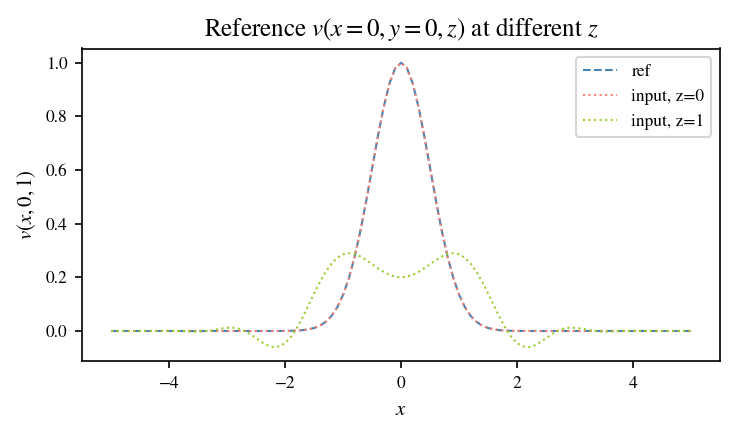

In [35]:
fig, ax1 = plt.subplots(1, figsize=(5,3), dpi=150)

ax1.plot(x_npmesh[0,:], v_exact_np(x_npmesh, 0, z_npmesh)[0,:], label='ref', linestyle='--')
ax1.plot(x_np, v_init(x_np,0), label='input, z=0', linestyle=':')
ax1.plot(x_np, v_exact_np(x_npmesh, 0, z_npmesh)[-1,:], label='input, z=1', linestyle=':')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$v(x,0,1)$')
#ax1.set_ylim(-3.1, 2.1)
ax1.set_title('Reference $v(x=0,y=0,z)$ at different $z$')
ax1.legend(loc='best')

fig.tight_layout()

plt.show()
plt.close()

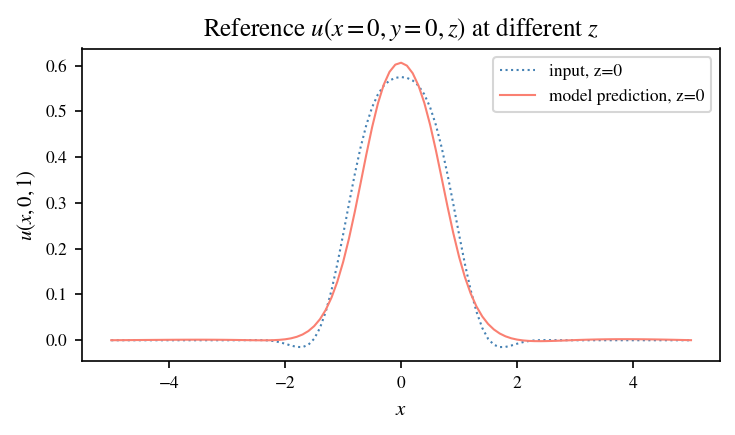

0.0005696334433042756
0.0004771501385064815


In [47]:
fig, ax1 = plt.subplots(1, figsize=(5,3), dpi=150)

pointatwhich = 43

ax1.plot(x_np, v_exact_np(x_npmesh, 0, z_npmesh)[pointatwhich,:], label='input, z=0', linestyle=':')
A_plot = model(XYZtest)
u_plot_pre = A_plot[:, 0:1]
v_plot_pre = A_plot[:, 1:2]
u_plot = (u_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
v_plot = (v_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, mid, :]
ax1.plot(x_np, v_plot[pointatwhich,:], label='model prediction, z=0')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(x,0,1)$')
#ax1.set_ylim(-3.1, 2.1)
ax1.set_title('Reference $u(x=0,y=0,z)$ at different $z$')
ax1.legend(loc='best')

fig.tight_layout()

plt.show()
plt.close()

print(u_exact_np(x_npmesh, 0, z_npmesh)[-1,10])
print(v_exact_np(x_npmesh, 0, z_npmesh)[-1,10])

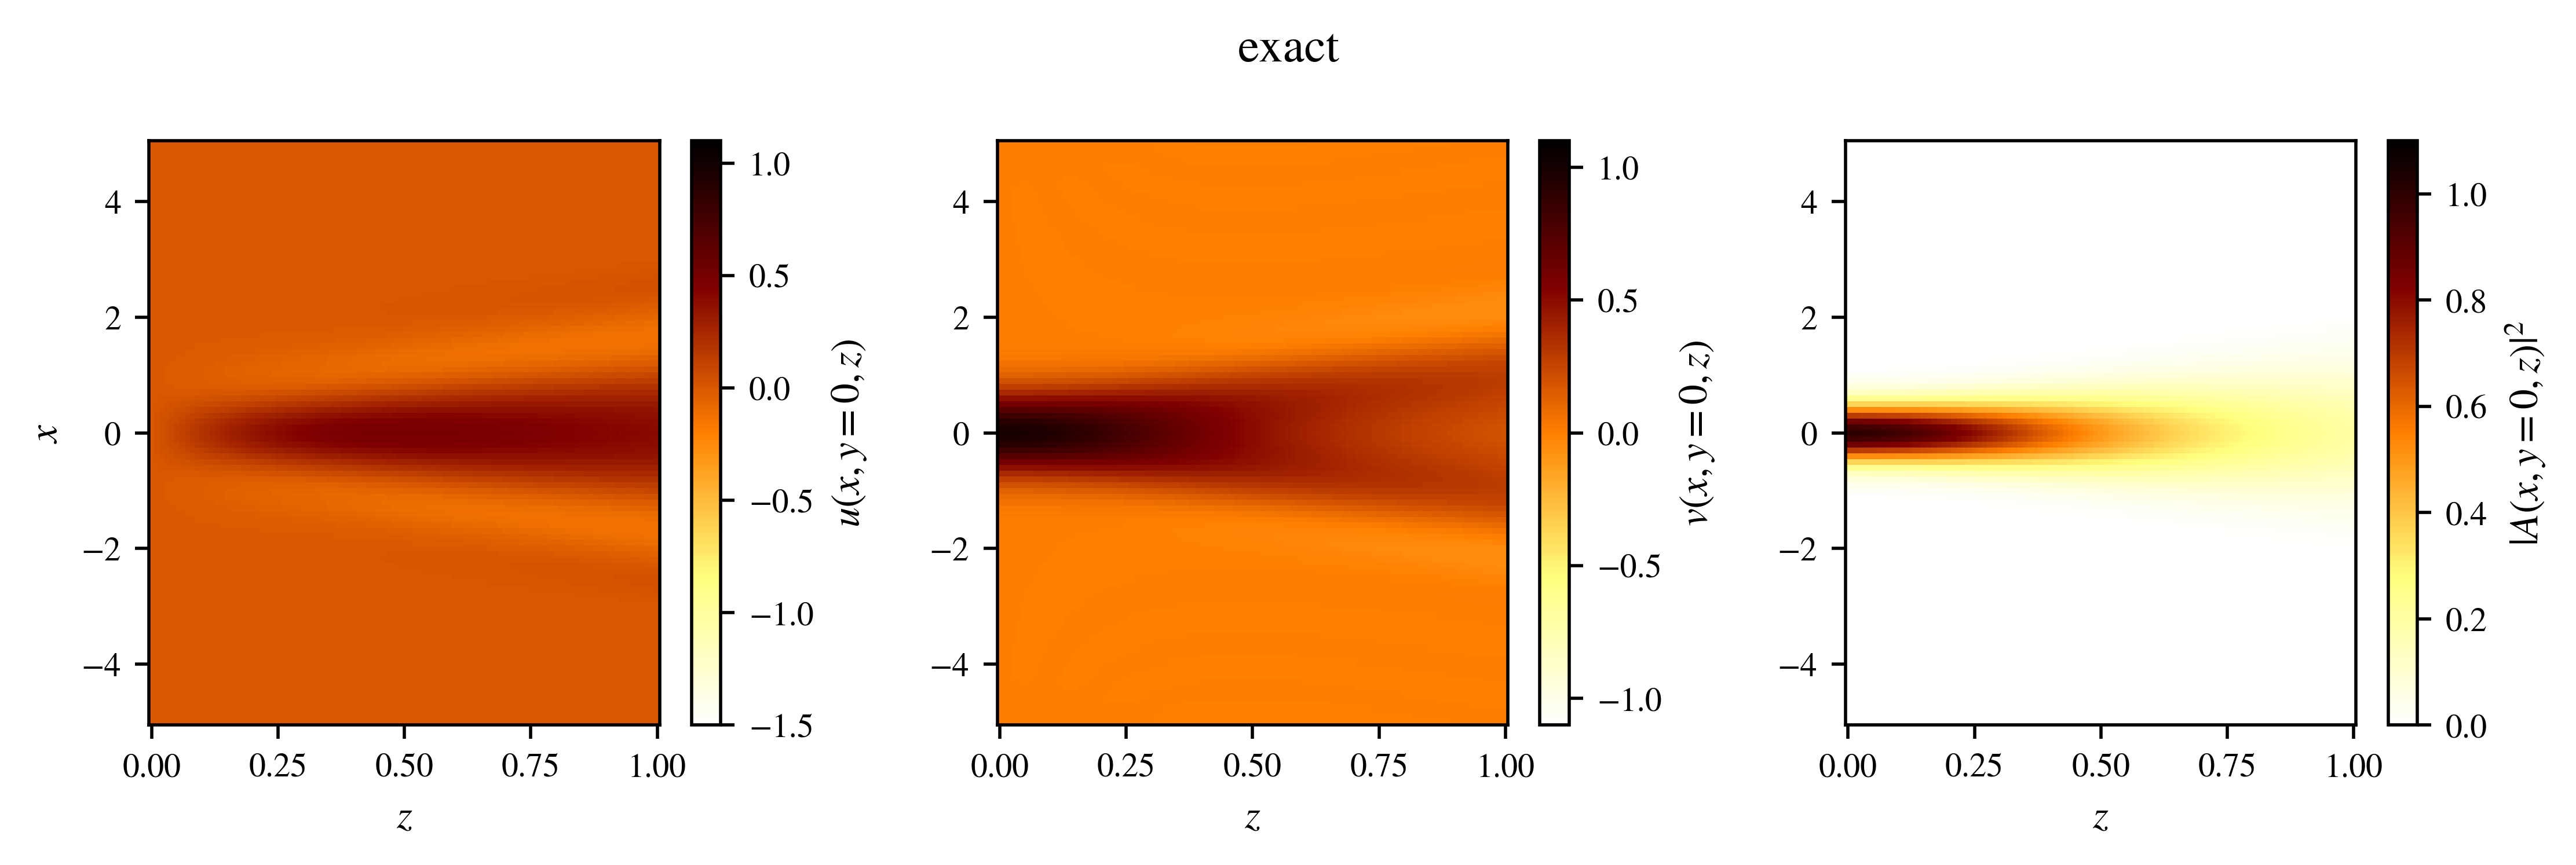

In [27]:
plot_reference()

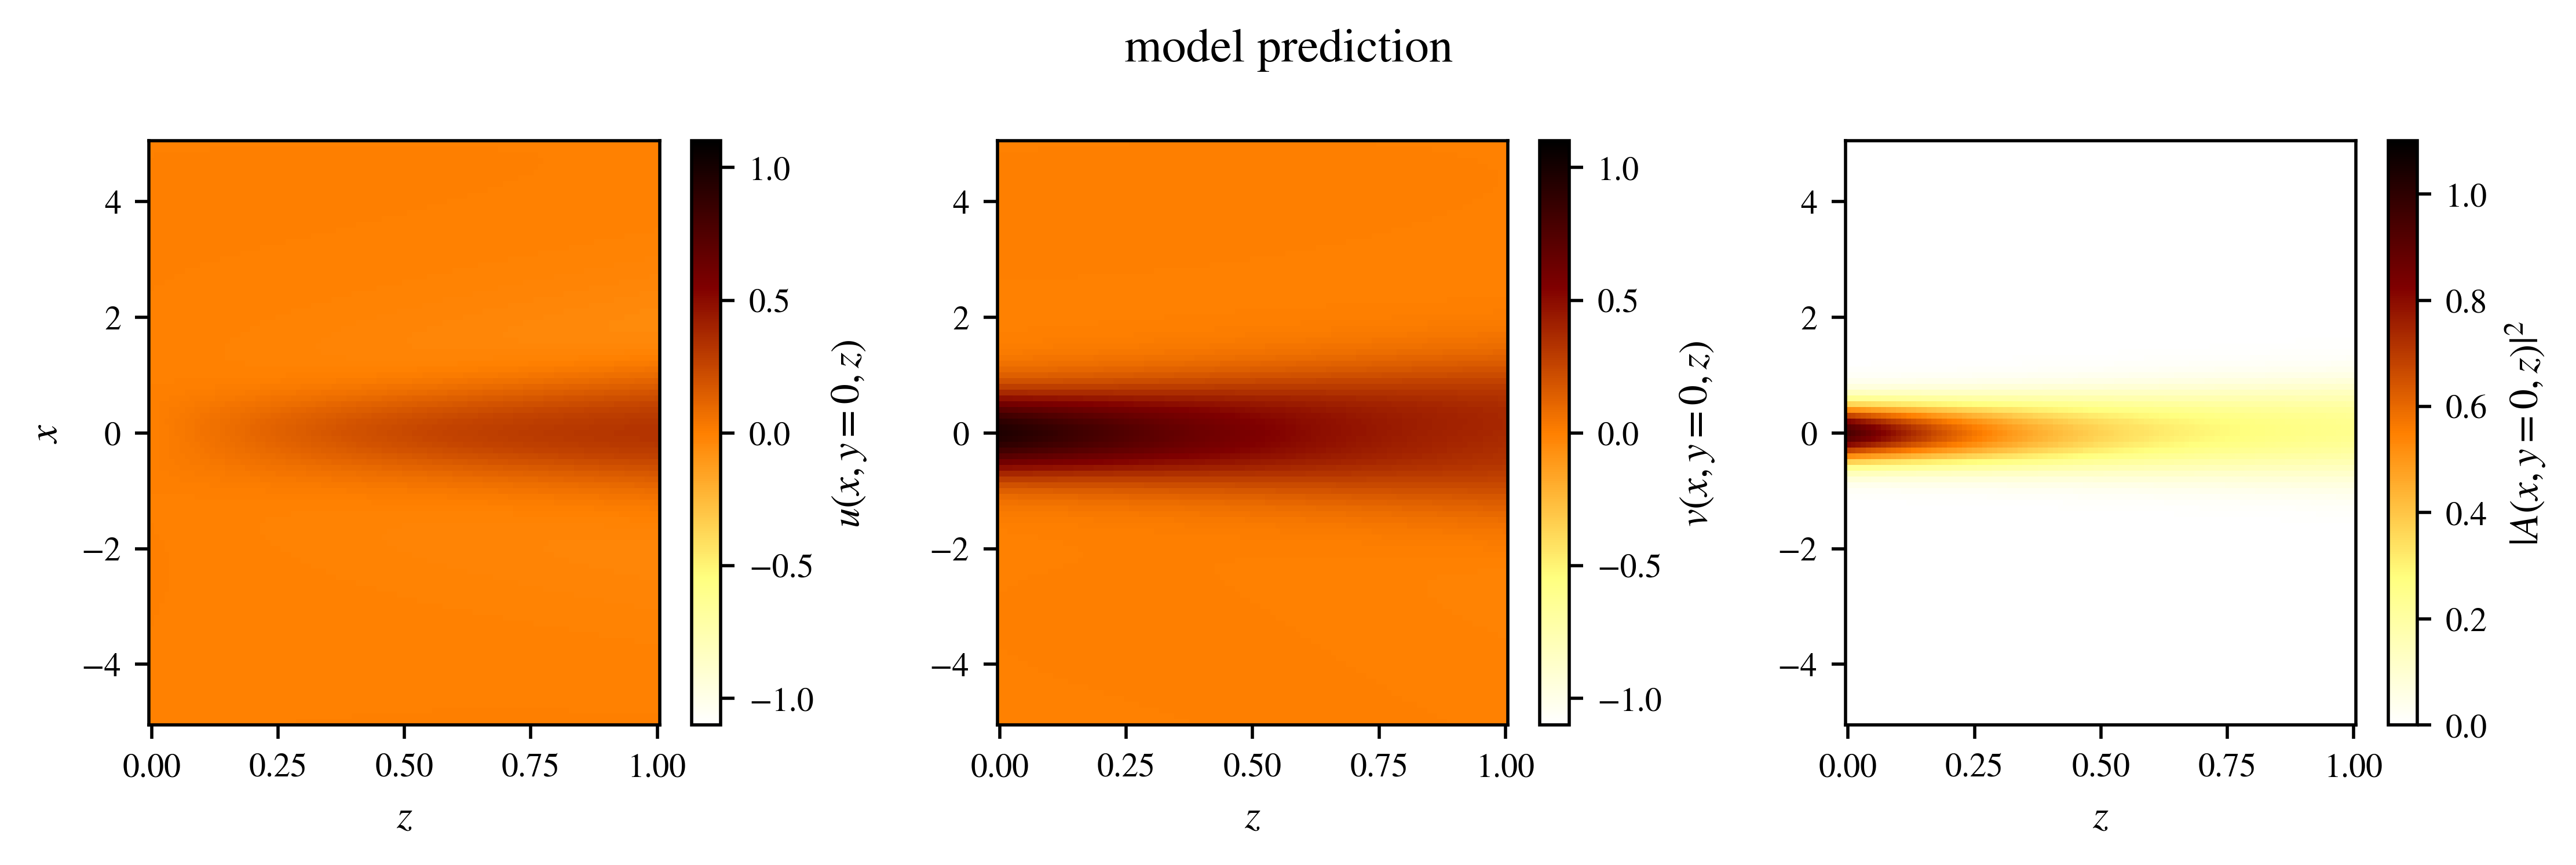

In [28]:
plot_model()

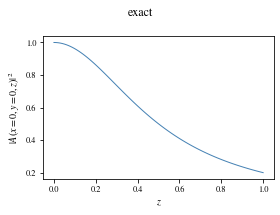

In [29]:
plot_reference_1D()

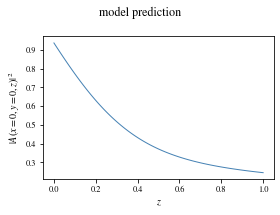

In [30]:
plot_model_1D()

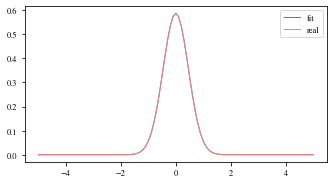

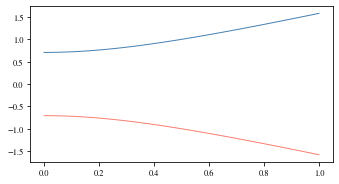

In [31]:
beam_diameter_exact(xtest, ztest)

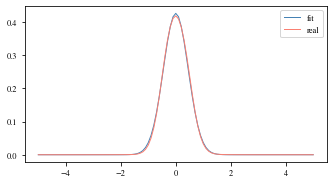

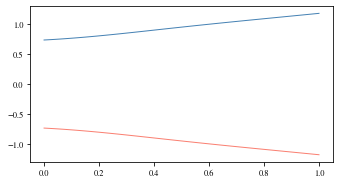

In [32]:
beam_diameter_predict(xtest, ztest)

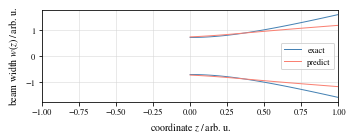

In [33]:
beam_diameter_compare(xtest, ztest)

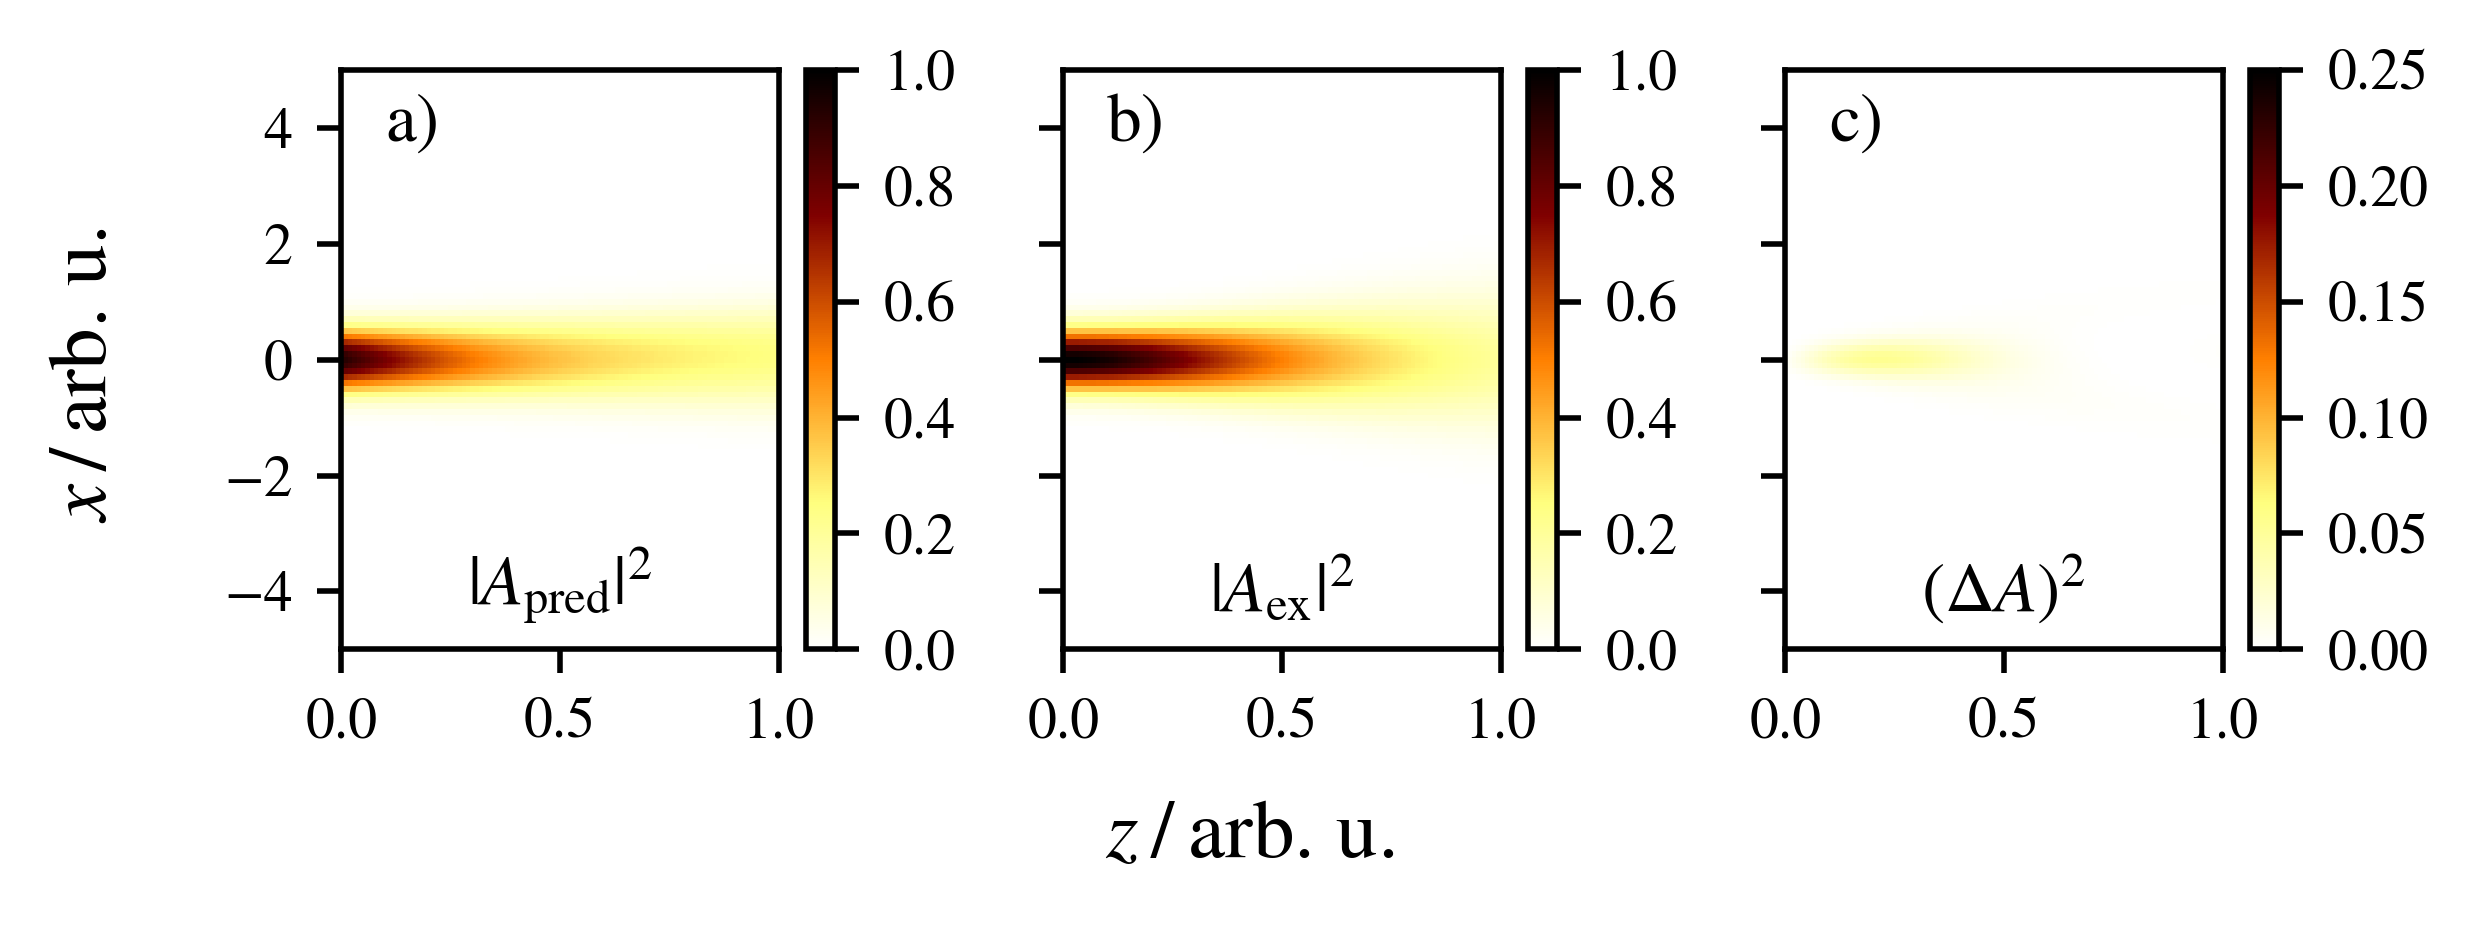

Relative L2 error is  0.02205484131178014


In [34]:
plot_compare_2D()